In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
#from open_spiel.python.algorithms import random_agent
from igraph import Graph

import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment

def input_graph(graph_path,file):
    GRAPH = Graph.Read_Ncol(graph_path+str(file)+".txt", directed=False)
    nodes = [v.index for v in GRAPH.vs]
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(GRAPH)  
    Graph.simplify(GRAPH)
    return GRAPH, map

def implement_GNN(model,parameter_path,GRAPH):
    params = Params(parameter_path)
    game = GraphGame
    env = Environment(game)
    attacker = DQN(state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    rewards, lcc, actions = EvaluateModel(env, attacker,GRAPH)
    '''agents = [random_agent.RandomAgent(player_id=0, num_actions=num_actions),random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
        rewards_random, lcc_random, _ = eval_model(env, agents)'''
    return rewards, lcc, actions

def implement_random_GNN(agents,GRAPH):
    game = GraphGame
    env = Environment(game)
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions
    
def implement_Bench(fname,GRAPH, map):
    '''game = GraphGame
    env = Environment(game)'''
    action_list = np.loadtxt(fname, dtype=int)
    rewards, lcc, actions = EvaluateACTION(action_list,GRAPH)
    return rewards, lcc, actions


def visual_evaluation(graph_path,file_list,attacker_ba, attacker_mix,title,plot_grid,grid): 
    if grid[0] * grid[1] < 10:
        figure, axis = plt.subplots(grid[0],grid[1],sharey=True,sharex=True,figsize=(12, 10))
    else :
        figure, axis = plt.subplots(grid[0],grid[1],sharey=True,sharex=True,figsize=(22, 20))
    AUC  = []
    NodeRemoved = []
    model_name = ["MIX","BA","FINDER","CI","GDM","COREHD"]
    for i, graph_name in enumerate(file_list):
        print(graph_name, end=' ,')
        GRAPH, map = input_graph(graph_path,graph_name)
        N = GRAPH.vcount()
        
        # Trained MIXED
        rewards_mix, lcc_mix, actions_mix = implement_GNN(attacker_mix[0],attacker_mix[1],GRAPH.copy())
        # Trained BA
        rewards_ba, lcc_ba, actions_ba = implement_GNN(attacker_ba[0],attacker_ba[1],GRAPH.copy())

        #FINDER MODEl
        #FINDER Best Re-Trained  iteration
        path = "./FINDER/FINDER_ReTrained/"
        fname = path+graph_name+".txt"
        rewards_Finder, lcc_Finder, actions_Finder = implement_Bench(fname,GRAPH.copy(),map)
        if (len(lcc_Finder) == 0):
            lcc_Finder = None
        #Re Insert CI
        path = "./ReI_CI/"
        fname = path+graph_name+".txt"
        rewards_ReI_CI, lcc_ReI_CI, actions_ReI_CI = implement_Bench(fname,GRAPH.copy(),map)
        #CI
        path = "./CI/"
        fname = path+graph_name+".txt"
        rewards_CI, lcc_CI, actions_CI = implement_Bench(fname,GRAPH.copy(),map)
        
        #GDM
        path = "./GDM/"
        fname = path+graph_name+".txt"
        rewards_GDM, lcc_GDM, actions_GDM = implement_Bench(fname,GRAPH.copy(),map)
       
        #CoreHD
        path = "./CoreHD/"
        fname = path+graph_name+".txt"
        rewards_CoreHD, lcc_CoreHD, actions_CoreHD =  implement_Bench(fname,GRAPH.copy(),map)
        
        '''#Random
        attacker = random_agent.RandomAgent(player_id=1, num_actions=N)
        rewards_random, lcc_random, actions_random = implement_random_GNN([attacker,attacker],GRAPH.copy())'''

        x =  np.flip(np.arange(N+1)[N:0:-1]/N)

        #Plot LCC Decrease
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_mix)],np.array(lcc_mix)/N, 'Green',label='Trained Attacker')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_ba)],np.array(lcc_ba)/N, 'Red',label='Trained Attacker [BA model]')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_Finder)],np.array(lcc_Finder)/N, 'Aquamarine',label='FINDER ReTrained')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_GDM)],np.array(lcc_GDM)/N, 'Blue',label='GDM')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_ReI_CI)],np.array(lcc_ReI_CI)/N, 'Pink',label='ReI_CI')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CI)],np.array(lcc_CI)/N, 'Orange',label='CI')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CoreHD)],np.array(lcc_CoreHD)/N, 'Brown',label='CoreHD')
        axis[plot_grid[i][0],plot_grid[i][1]].set_title(graph_name, fontdict={'fontsize': 18})
        #plt.plot(x[:len(lcc_random)],np.array(lcc_random)/N, 'blue',label='Random')
        #Compute Area under the curve
        auc_mix = area_under_curve(x[:len(lcc_mix)],lcc_mix)
        auc_ba =  area_under_curve(x[:len(lcc_ba)],lcc_ba)
        auc_Finder = area_under_curve(x[:len(lcc_Finder)],lcc_Finder)
        auc_GDM = area_under_curve(x[:len(lcc_GDM)],lcc_GDM)
        auc_ReI_CI = area_under_curve(x[:len(lcc_ReI_CI)],lcc_ReI_CI)
        auc_CI = area_under_curve(x[:len(lcc_CI)],lcc_CI)
        auc_CoreHD = area_under_curve(x[:len(lcc_CoreHD)],lcc_CoreHD)
        auc_all = np.array([auc_mix,auc_ba,auc_Finder,auc_ReI_CI,auc_CI,auc_GDM,auc_CoreHD],dtype='O')
        
        actions_all = [actions_mix,actions_ba,actions_Finder,actions_ReI_CI,actions_CI,actions_GDM,actions_CoreHD]
        fractionNode = np.array([len(xi) for xi in actions_all],dtype='O')/N
        
        #Save it as a string array
        auc_idx = np.argmin(np.array(auc_all,dtype='O')) # index of best auc
        fracNode_idx = np.argmin(np.array(fractionNode ,dtype='O')) # index of best fraction_node
        auc_all= ["%.4f" % action for action in auc_all]
        fractionNode= ["%.3f" % action for action in fractionNode]
        auc_all[auc_idx] = r"\cellcolor{blue!25}"+ str(auc_all[auc_idx])
        fractionNode[auc_idx] = r'\cellcolor{blue!25}'+ str(fractionNode[fracNode_idx])
        AUC.append(np.insert(auc_all,0,graph_name.replace("_", " ")))
        NodeRemoved.append(np.insert(fractionNode,0,graph_name.replace("_", " ")))
    print()
    np.savetxt("./Figure/Compiled/HDA/AUC_"+title+".tex", AUC,delimiter=" & ",newline = "\\\\ \n", fmt=('%s','%s','%s','%s','%s','%s','%s','%s')) 
    np.savetxt("./Figure/Compiled/HDA/Removed_"+title+".tex", NodeRemoved,delimiter=" & ",newline = "\\\\ \n",fmt=('%s','%s','%s','%s','%s','%s','%s','%s')) 
    figure.text(0.5, 0.075,"Fraction of Nodes Removed" , fontsize = 18,  ha='center')
    figure.text(0.075, 0.5, "LCC/No. of Nodes", fontsize = 18,  va='center', rotation='vertical')
    #plt.title("LCC vs No. of Nodes for Agents")
    #plt.legend(handles=[l1, l2, l3, l4, l5, l6, l7],loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, fancybox=True, shadow=True, bbox_transform=figure.transFigure)
    plt.savefig("./Figure/Compiled/HDA/"+title+".pdf")
    plt.show()

# Synthetic Network:- Heterogeneity and Homogeneity

heterogeneous_30 ,heterogeneous_50 ,heterogeneous_100 ,heterogeneous_500 ,


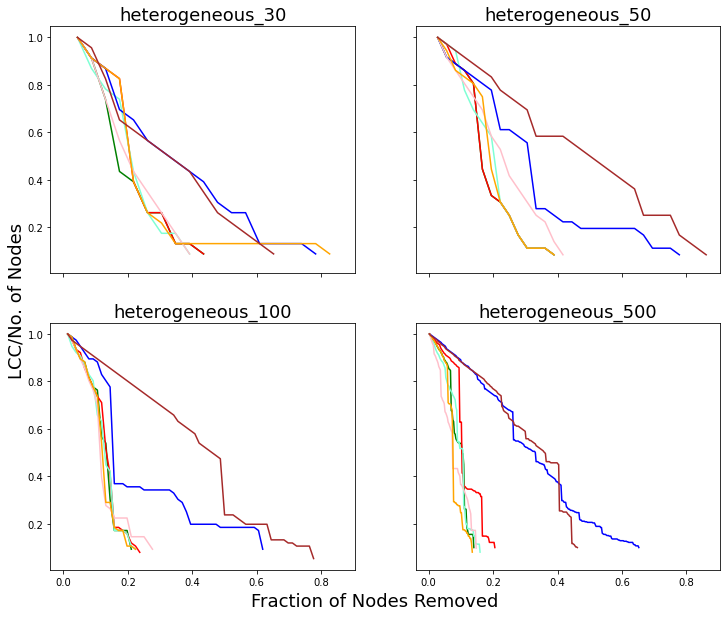

In [2]:
#BA 474500 #Homo 59000 #Hetero 348500#Tree 476000#
#BA 429000 # Homo 461500 #Hetero 5000 #Tree 1000 #
BA = 263500
MIX = 80000 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
#attacker= [torch.load('./model/DiffSize_BA_Graph_HDgreedy_CI/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_HDgreedy_CI/model_differentGraph_'+str(MIX))]
attacker= [torch.load('./model/DiffSize_BA_Graph_TS/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_TS/model_differentGraph_'+str(MIX))]
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['heterogeneous_30','heterogeneous_50','heterogeneous_100','heterogeneous_500']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"heterogeneous",[[0,0],[0,1],[1,0],[1,1]],[2,2])



homogeneous_30 ,homogeneous_50 ,homogeneous_100 ,homogeneous_500 ,


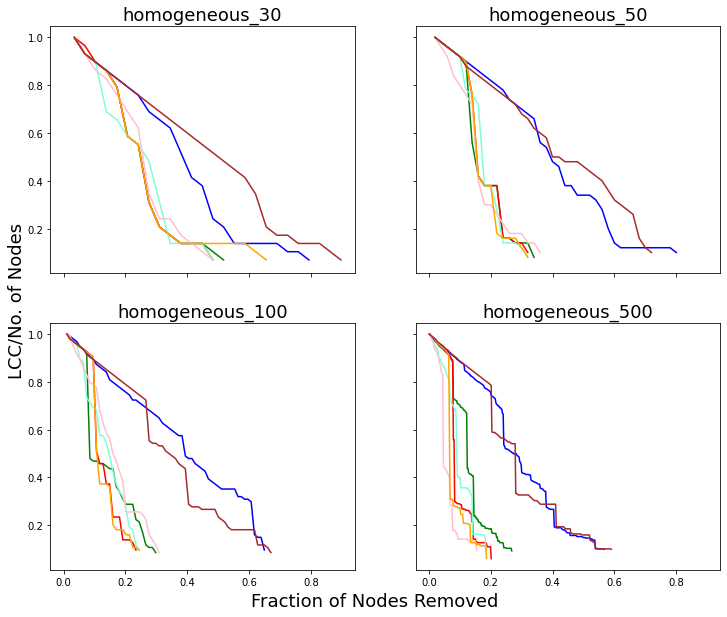

In [3]:
BA = 188000 
MIX = 380000
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_TS/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_TS/model_differentGraph_'+str(MIX))]
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['homogeneous_30','homogeneous_50','homogeneous_100','homogeneous_500']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"homogeneous",[[0,0],[0,1],[1,0],[1,1]],[2,2])

# Synthetic with Motifs Attached

ba_300_20_house_1 ,ba_300_40_house_2 ,ba_300_60_house_3 ,ba_300_80_house_4 ,ba_300_100_house_5 ,ba_300_20_fan_1 ,ba_300_40_fan_2 ,ba_300_60_fan_3 ,ba_300_80_fan_4 ,ba_300_100_fan_5 ,ba_300_20_clique_1 ,ba_300_40_clique_2 ,ba_300_60_clique_3 ,ba_300_80_clique_4 ,ba_300_100_clique_5 ,ba_300_20_diamond_1 ,ba_300_40_diamond_2 ,ba_300_60_diamond_3 ,ba_300_80_diamond_4 ,ba_300_100_diamond_5 ,ba_300_20_cycle_1 ,ba_300_40_cycle_2 ,ba_300_60_cycle_3 ,ba_300_80_cycle_4 ,ba_300_20_star_1 ,ba_300_40_star_2 ,ba_300_60_star_3 ,ba_300_80_star_4 ,ba_300_100_star_5 ,ba_300_20_grid_1 ,ba_300_40_grid_2 ,ba_300_60_grid_3 ,ba_300_80_grid_4 ,ba_300_100_grid_5 ,


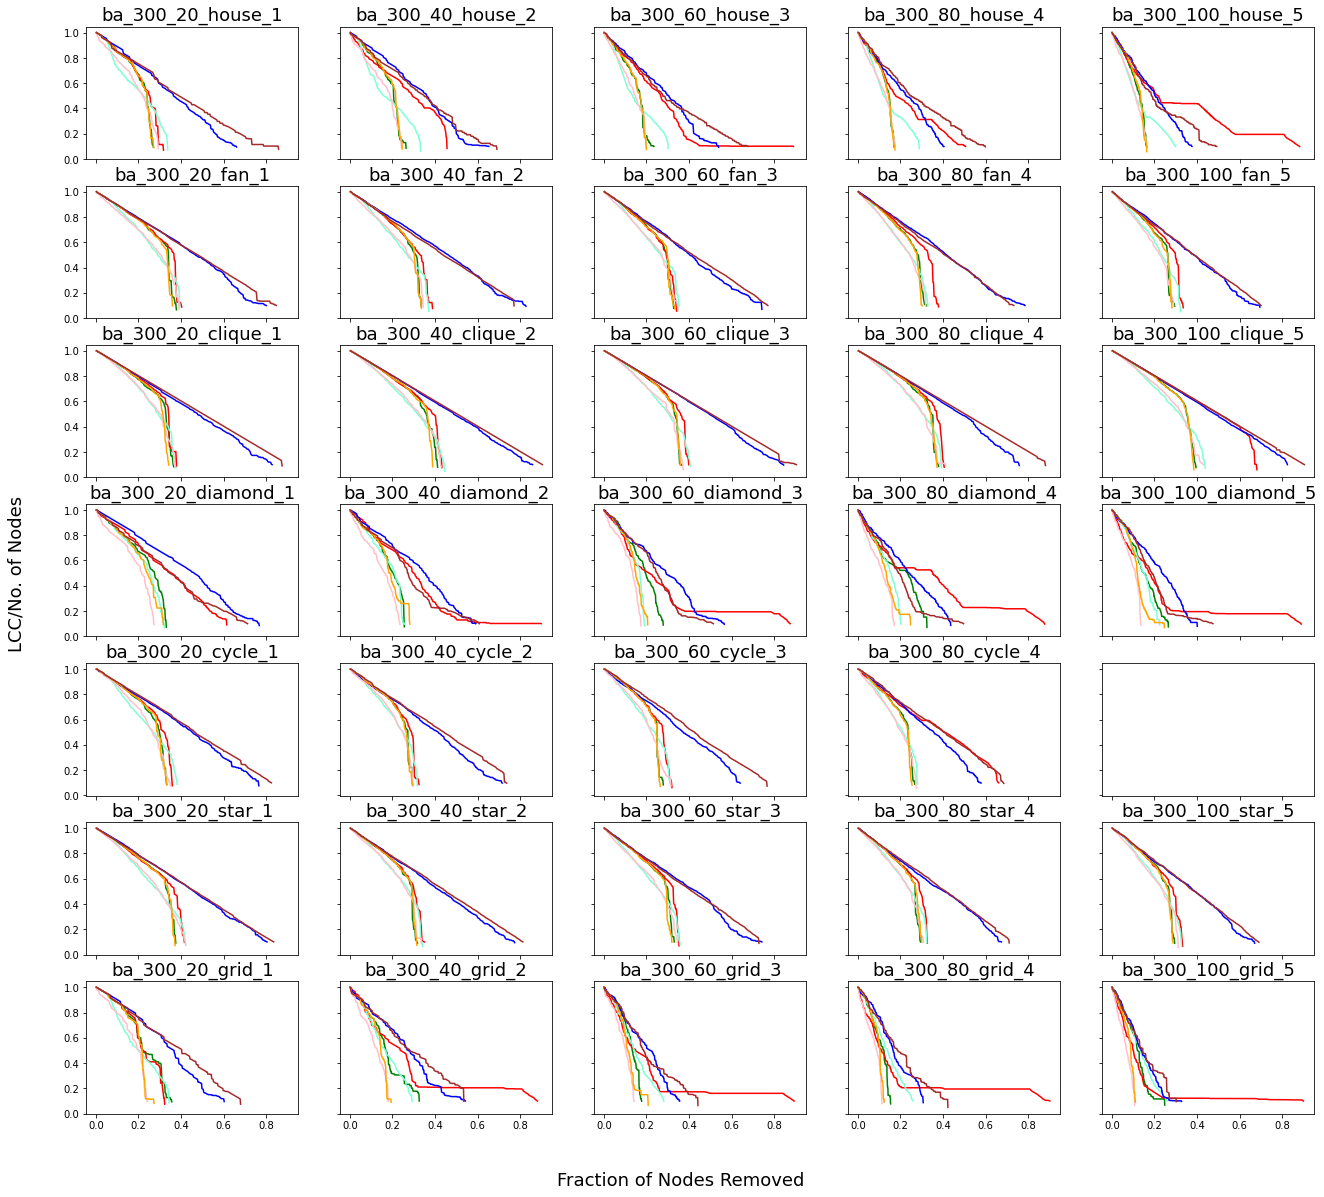

In [8]:
BA = 263500
MIX = 80000 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_TS/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_TS/model_differentGraph_'+str(MIX))]
# 'ba_300_100_cycle_5',
file_list = ['ba_300_20_house_1', 'ba_300_40_house_2', 'ba_300_60_house_3', 'ba_300_80_house_4', 'ba_300_100_house_5', 'ba_300_20_fan_1', 'ba_300_40_fan_2', 'ba_300_60_fan_3', 'ba_300_80_fan_4', 'ba_300_100_fan_5', 'ba_300_20_clique_1', 'ba_300_40_clique_2', 'ba_300_60_clique_3', 'ba_300_80_clique_4', 'ba_300_100_clique_5', 'ba_300_20_diamond_1', 'ba_300_40_diamond_2', 'ba_300_60_diamond_3', 'ba_300_80_diamond_4', 'ba_300_100_diamond_5', 'ba_300_20_cycle_1', 'ba_300_40_cycle_2', 'ba_300_60_cycle_3', 'ba_300_80_cycle_4','ba_300_20_star_1', 'ba_300_40_star_2', 'ba_300_60_star_3', 'ba_300_80_star_4', 'ba_300_100_star_5', 'ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5']
graph_path = "./Dataset/Validation/Motifs_Attached/BA/"
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
grid_plot.pop((5*5 -1))
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"BA_Motifs",grid_plot,[x,y])


tree_8_20_house_1 ,tree_8_40_house_2 ,tree_8_60_house_3 ,tree_8_80_house_4 ,tree_8_100_house_5 ,tree_8_20_fan_1 ,tree_8_40_fan_2 ,tree_8_60_fan_3 ,tree_8_80_fan_4 ,tree_8_100_fan_5 ,tree_8_20_clique_1 ,tree_8_40_clique_2 ,tree_8_60_clique_3 ,tree_8_80_clique_4 ,tree_8_100_clique_5 ,tree_8_20_diamond_1 ,tree_8_40_diamond_2 ,tree_8_60_diamond_3 ,tree_8_80_diamond_4 ,tree_8_100_diamond_5 ,tree_8_20_cycle_1 ,tree_8_40_cycle_2 ,tree_8_60_cycle_3 ,tree_8_80_cycle_4 ,tree_8_100_cycle_5 ,tree_8_20_star_1 ,tree_8_40_star_2 ,tree_8_60_star_3 ,tree_8_80_star_4 ,tree_8_100_star_5 ,tree_8_20_grid_1 ,tree_8_40_grid_2 ,tree_8_60_grid_3 ,tree_8_80_grid_4 ,tree_8_100_grid_5 ,


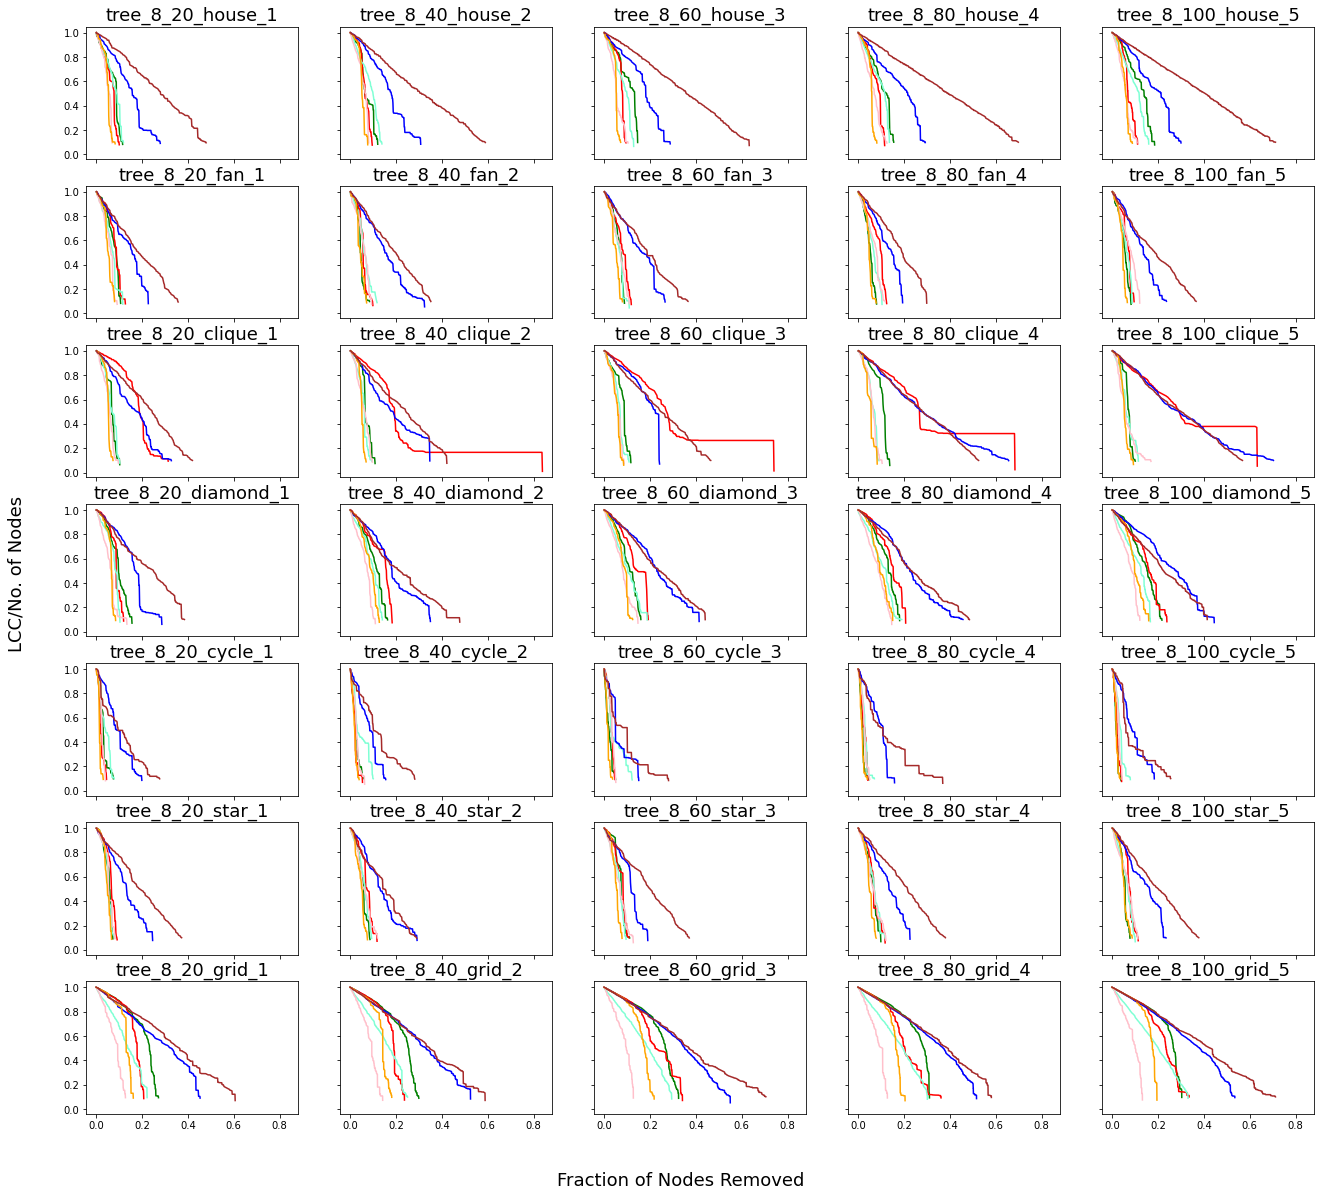

In [2]:
BA = 263500
MIX = 80000 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_TS/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_TS/model_differentGraph_'+str(MIX))]

file_list = ['tree_8_20_house_1', 'tree_8_40_house_2', 'tree_8_60_house_3', 'tree_8_80_house_4', 'tree_8_100_house_5', 'tree_8_20_fan_1', 'tree_8_40_fan_2', 'tree_8_60_fan_3', 'tree_8_80_fan_4', 'tree_8_100_fan_5', 'tree_8_20_clique_1', 'tree_8_40_clique_2', 'tree_8_60_clique_3', 'tree_8_80_clique_4', 'tree_8_100_clique_5', 'tree_8_20_diamond_1', 'tree_8_40_diamond_2', 'tree_8_60_diamond_3', 'tree_8_80_diamond_4', 'tree_8_100_diamond_5', 'tree_8_20_cycle_1', 'tree_8_40_cycle_2', 'tree_8_60_cycle_3', 'tree_8_80_cycle_4', 'tree_8_100_cycle_5', 'tree_8_20_star_1', 'tree_8_40_star_2', 'tree_8_60_star_3', 'tree_8_80_star_4', 'tree_8_100_star_5', 'tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3','tree_8_80_grid_4', 'tree_8_100_grid_5']
graph_path ="./Dataset/Validation/Motifs_Attached/Tree/" 
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#[print(i,file_list[i],grid_plot[i][0],grid_plot[i][1]) for i in range(x*y)]
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Tree_Motifs",grid_plot,[x,y])


# Real World Dataset

In [ ]:
BA = 263500
MIX = 80000 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_TS/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_TS/model_differentGraph_'+str(MIX))]

file_list = ["corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience','HI-II-14']
graph_path =  "./Dataset/Real/"
x, y = 3, 4
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#[print(i,file_list[i],grid_plot[i][0],grid_plot[i][1]) for i in range(x*y)]
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Real",grid_plot,[x,y])


corruption ,foodweb-baywet ,inf-USAir97 ,moreno_crime_projected ,opsahl-openflights ,household ,faa ,facebook ,

## Cancer Gene

In [ ]:
graph_path = "./Dataset/GeneNetwork/"
file_list =  ["COAD","HNSC","KICH","PRAD","UCEC"]
x, y = 2, 3
grid_plot = [[i,j] for i in range(x) for j in range(y)]
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Cancer_Gene",grid_plot,[x,y])